# Example: 1D Oscillator - Part 4/5

- Author: Dr. Daning Huang
- Date: 01/03/2026

In this part, we explore the use of sequential dynamics models (SDMs) for data with time delay.

Meanwhile, since the model starts to be more complex, we will also show how to visualize the model structure to understand/debug the model.

## Formulation

Consider $T$ steps of observations $x_{1:T}$ and inputs $u_{1:T}$, SDMs map these to a $T$-step sequence of latent states $z_{1:T}$, and predict $z_{T+1}$.  Formally, we can write

- Encoder: $z_{1:T}=f_E(x_{1:T}, u_{1:T})$
- Dynamics: $z_{T+1}=f_P(z_{1:T})$, then assemble $z_{2:T+1}=[z_{2:T}, z_{T+1}]$
- Decoder: $x_{2:T+1}=f_D(z_{2:T+1})$

In practice, either $f_E$ or $f_P$ can be sequential modules, e.g., RNNs.  For technical details, one can refer to the [theory documentation](https://dymad.readthedocs.io/en/latest/theory/architecture.html).

In this example, we demonstrate two SDM architectures,

- Stepwise MLP's as encoder and decoder, RNN as processor
- RNN as encoder, brutal force MLP as processor, stepwise MLP as decoder

## Preparation

Same drill like before.

In [1]:
import copy
import numpy as np
import torch

from dymad.io import load_model, visualize_model  # New function
from dymad.models import DSDM                     # New model
from dymad.training import NODETrainer            # For discrete-time model
from dymad.utils import plot_trajectory, TrajectorySampler

In [2]:
B = 128   # Number of trajectories
N = 501   # Number of steps
t_grid = np.linspace(0, 5, N)

A = np.array([
            [0., 1.],
            [-1., -0.1]])
def f(t, z, u):               # Define the dynamics
    return (z @ A.T) + u
g = lambda t, z, u: z         # Define the observation

# Chirp input for training
config_chr = {
    "control" : {
        "kind": "chirp",
        "params": {
            "t1": 4.0,
            "freq_range": (0.5, 2.0),
            "amp_range": (0.5, 1.0),
            "phase_range": (0.0, 360.0)}}}

# Random Gaussian input for testing/generalization
config_gau = {
    "control" : {
        "kind": "gaussian",
        "params": {
            "mean": 0.5,
            "std":  1.0,
            "t1":   4.0,
            "dt":   0.2,
            "mode": "zoh"}}}

# Generate data
sampler_chr = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_chr)
ts, zs, us, xs = sampler_chr.sample(t_grid, batch=B, save='./data/lti.npz')

sampler_gau = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_gau)

Set up the options for the trainer, where

- We only consider time delay in data transformation for simplicity.
- The `latent_dimension` is the dimension of $z_{1:T}$; in the current case $T=2$ so each $z$ is 4-dimensional.
- Note the new options `autoencoder_type` and `processor_type` that specifies the SDM.
- We use trajectory chopping and sweeping to enhance the training.

In [3]:
opt_case1 = {
    "transform_x": {"type": "delay", "delay": 1},
    "transform_u": {"type": "delay", "delay": 1},
    "model": {
      "name" : 'ltd_sdm_smp',
      "autoencoder_type" : 'seq_smp',  # Stepwise MLP as encoder/decoder
      "encoder_layers" : 1,
      "decoder_layers" : 1,
      "processor_layers" : 1,          # RNN as processor by default
      "hidden_dimension" : 16,
      "latent_dimension" : 8,
      "activation" : "none",           # Linear model as the underlying data is linear
      "weight_init" : "xavier_uniform",
      "gain" : 0.01                    # Smaller initialization for more stable training
    },
    "criterion": {
        "dynamics" : {"weight" : 1.0},
        "recon" : {"weight" : 1.0}
    },
    "training" : {
      "n_epochs": 500,
      "save_interval": 10,
      "load_checkpoint": False,
      "learning_rate": 5e-3,
      "decay_rate": 0.999,
      "chop_mode": "unfold",
      "chop_step": 0.5,
      "sweep_lengths": [3, 5, 7],
      "sweep_epoch_step": 200
}}
opt_case2 = copy.deepcopy(opt_case1)
opt_case2["model"]["name"] = 'ltd_sdm_std'
opt_case2["model"]["autoencoder_type"] = 'seq_std'    # RNN as encoder, MLP as decoder
opt_case2["model"]["processor_type"] = 'mlp_smp'      # Brutal force MLP as processor

opts = [opt_case1, opt_case2]
IDX  = [0, 1]
labels = [opts[_i]["model"]['name'] for _i in IDX]

## Training

In [4]:
config_path = 'lti_model.yaml'
for _i in IDX:
    trainer = NODETrainer(config_path, DSDM, config_mod=opts[_i])
    trainer.train();

## Results

### Prediction

We first check the model prediction.  Again due to time delay, `t_data` is reduced by 1 step during prediction.  Both models appear to work OK.

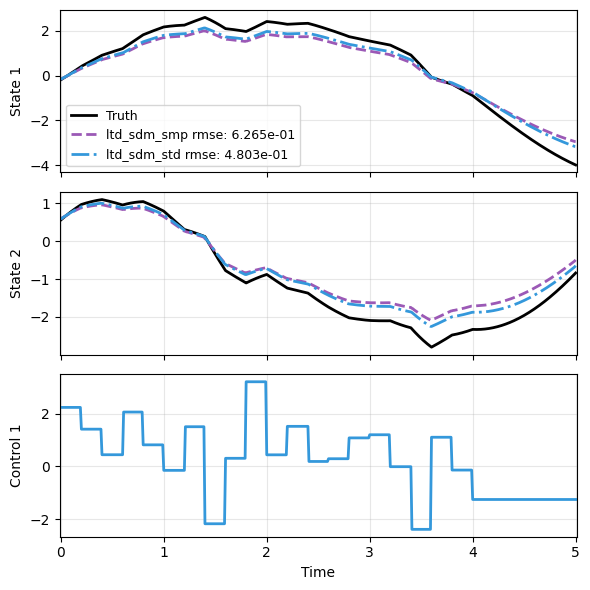

In [6]:
sampler = TrajectorySampler(f, g, config='lti_data.yaml', config_mod=config_gau)

ts, xs, us, ys = sampler.sample(t_grid, batch=1)
x_data, t_data, u_data = xs[0], ts[0], us[0]

res = [x_data]
for _i in IDX:
    _, prd_func = load_model(DSDM, f'{labels[_i]}.pt')
    with torch.no_grad():
        _pred = prd_func(x_data, t_data[:-1], u=u_data)
    res.append(_pred)

plot_trajectory(
    np.array(res), t_data, "LTD",
    us=u_data, labels=['Truth']+labels, ifclose=False);

### Model visualization

`DyMAD` provides `visualize_model` to show the architecture of a model, including the input/output dimensions of each layer.  The tool is based on the `torchview` package.

Unfortunately, at the point of writing, the tool has two limitations:

- It cannot differentiate among inputs and among outputs, so they are uniformly labelled as `input-tensor`s and `output-tensor`s, respectively.  One needs to infer the specific input/output based on the graph.
- The inputs go through some bookkeeping blocks such as `__getitem__`, which is only for generating dimensionally consistent data.  One should ignore these blocks.

In [7]:
graphs = []
for _i in IDX:
    model_graph = visualize_model(
        mdl_class=DSDM,                       # Model class
        checkpoint_path=f'{labels[_i]}.pt',   # Checkpoint of the model
        ref_data='./data/lti.npz',            # Reference dataset to determine input dimensions
        depth=1,                              # Level of details, the higher the more
        ifsave=False)
    graphs.append(model_graph)

Below is the first case.  The left `input-tensor` is not used, and would be the time $t$; the middle one would be the initial condition $x_0$, given the dimension (raw $x$ is 2D, time delay $T=2$, so $4=2\times 2$); the right one would be the inputs $u$ (raw $u$ is 1D and $2=1\times 2$).

Next, we see that $x_0$ and $u$ are passed into `StepwiseModel`, which would be the encoder, as we have specified.  The single output on the right produced by `StepwiseModel` would be the latent states $z$.  The output also passes to another `StepwiseModel`, which would be the decoder, again as we have specified; the output is the decoded $x$.

The remaining branch is then apparently for `SimpleRNN` as processor.  It takes input dimension of 8, for $z_{1:2}$, and returns dimension 4 for $z_3$.  The `__getitem__` obtains $z_2$ and later `cat` concatenates the two pieces into $z_{2:3}$, of dimension 8.

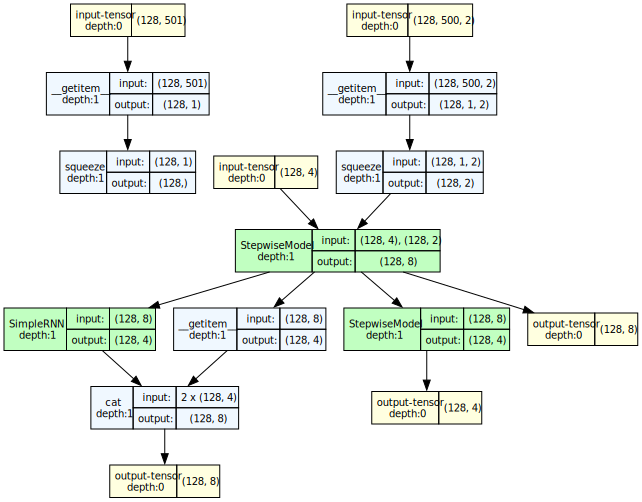

In [8]:
graphs[0]    # ltd_sdm_smp

Next, the second case.  Using the same reasoning as before, the inputs from left to right are $t$, $x$, $u$, respectively.  This time `SimpleRNN` is used as encoder, and its output is passed to a brutal force `MLP` for processing and a `StepwiseModel` to decode.

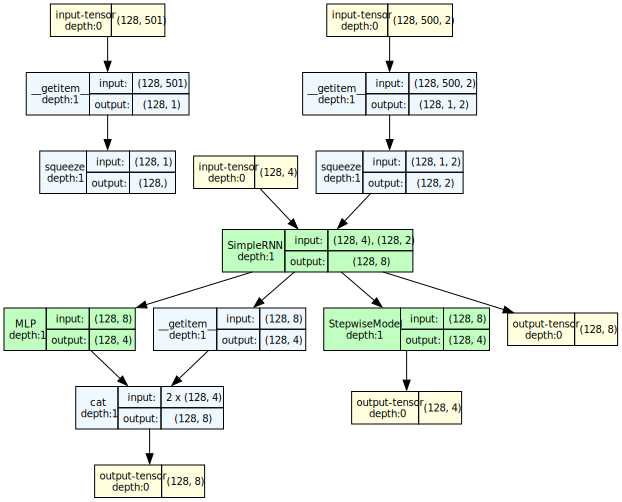

In [9]:
graphs[1]    # ltd_sdm_std